## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50, vit_b_16
import timm

## Config

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:

metadata_path = '../data/balanced_data/normalized_metadata.csv'
normalization_params_path = '../data/balanced_data/normalization_params.json'
image_dir = '../data/balanced_data'
pretrained_conformer_path = './pretrained_models/conformer.pth'
pretrained_dnn_path = './pretrained_models/dnn.pth'
pretrained_vit_path = './pretrained_models/vit_classifier.pth'
fusion_model_save_path = './fusion_model.pth'

In [ ]:

with open(normalization_params_path, 'r') as f:
    normalization_params = json.load(f)

## Dataset

In [ ]:
class FusionDataset(Dataset):
    def __init__(self, metadata_path, image_dir, normalization_params, transform_conformer, transform_vit):
        self.metadata = pd.read_csv(metadata_path)
        self.image_dir = image_dir
        self.transform_conformer = transform_conformer
        self.transform_vit = transform_vit
        self.labels = self.metadata['target'].values.astype(int)
        
        
        columns_to_drop = [
            "isic_id", "target", "patient_id", "anatom_site_general", "image_type",
            "tbp_tile_type", "attribution", "copyright_license", "lesion_id", "iddx_full",
            "iddx_1", "iddx_2", "iddx_3", "iddx_4", "iddx_5", "mel_mitotic_index",
            "mel_thick_mm", "tbp_lv_dnn_lesion_confidence"
        ]
        metadata_features = self.metadata.drop(columns=columns_to_drop, errors='ignore')
        for col, params in normalization_params.items():
            if col in metadata_features.columns:
                col_min = params['min']
                col_max = params['max']
                metadata_features[col] = (metadata_features[col] - col_min) / (col_max - col_min)
        self.metadata_features = metadata_features.values.astype(np.float32)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        isic_id = self.metadata.iloc[idx]['isic_id']
        label = self.labels[idx]
        metadata_features = torch.tensor(self.metadata_features[idx], dtype=torch.float32)
        folder = '1' if label == 1 else '0'
        image_path = os.path.join(self.image_dir, folder, f"{isic_id}.jpg")
        image = Image.open(image_path).convert("RGB")

        
        image_conformer = self.transform_conformer(image)
        image_vit = self.transform_vit(image)

        
        label = torch.tensor(label, dtype=torch.long)

        return image_conformer, image_vit, metadata_features, label


In [ ]:

transform_conformer = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:



dataset = FusionDataset(
    metadata_path=metadata_path,
    image_dir=image_dir,
    normalization_params=normalization_params,
    transform_conformer=transform_conformer,
    transform_vit=transform_vit
)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.labels,
    random_state=SEED
)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=dataset.labels[temp_indices],
    random_state=SEED
)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")


Train size: 607, Validation size: 76, Test size: 76


## Architecture

In [ ]:
class ConformerTinyBinary(nn.Module):
    def __init__(self, img_size=128, num_classes=2, embed_dim=256, num_heads=8, num_transformer_layers=3, dropout=0.2):
        super(ConformerTinyBinary, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout)
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_transformer_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  
        x = self.transformer(x)
        x = x.mean(dim=0)  
        return x

In [10]:
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class FusionModel(nn.Module):
    def __init__(self, conformer, feedforward, resnet, vit, conformer_embed_dim, feedforward_embed_dim, resnet_embed_dim, vit_embed_dim, fusion_hidden_dim, output_dim=2, dropout_rate=0.2):
        super(FusionModel, self).__init__()
        self.conformer = conformer
        self.feedforward = feedforward
        self.resnet = resnet
        self.vit = vit

        
        total_embed_dim = conformer_embed_dim + feedforward_embed_dim + resnet_embed_dim + vit_embed_dim

        self.fusion_fc = nn.Sequential(
            nn.Linear(total_embed_dim, fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_hidden_dim, output_dim)
        )

    def forward(self, image_conformer, image_vit, metadata):
        
        x_conformer = self.conformer.conv(image_conformer)
        b, c, h, w = x_conformer.shape
        x_conformer = x_conformer.view(b, c, -1).permute(2, 0, 1)
        x_conformer = self.conformer.transformer(x_conformer)
        conformer_embed = x_conformer.mean(dim=0)  

        
        metadata_embed = self.feedforward.fc[:-1](metadata)  

        
        with torch.no_grad():  
            resnet_embed = self.resnet(image_vit).squeeze()  

        with torch.no_grad():  
            vit_embed = self.vit(image_vit)  

        
        
        
        
        

        
        fusion_input = torch.cat((conformer_embed, metadata_embed, resnet_embed, vit_embed), dim=1)

        
        

        output = self.fusion_fc(fusion_input)
        return output


## Init

In [ ]:
pretrained_resnet_path = './pretrained_models/resnet50.pth'

if os.path.exists(pretrained_resnet_path):
    print(f"Loading ResNet-50 from {pretrained_resnet_path}")
    resnet = resnet50()
    resnet.load_state_dict(torch.load(pretrained_resnet_path, map_location=device))
else:
    print("Downloading ResNet-50 pretrained weights...")
    resnet = resnet50(pretrained=True)
    os.makedirs(os.path.dirname(pretrained_resnet_path), exist_ok=True)
    torch.save(resnet.state_dict(), pretrained_resnet_path)
    print(f"ResNet-50 weights saved to {pretrained_resnet_path}")

resnet.fc = nn.Identity()



Loading ResNet-50 from ./pretrained_models/resnet50.pth


C:\Users\jonec\AppData\Local\Temp\ipykernel_16348\4186524744.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(pretrained_resnet_path, ma

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


vit = timm.create_model(
    'vit_base_patch16_224.augreg2_in21k_ft_in1k',  
    pretrained=False,  
    num_classes=0      
)


num_features = vit.embed_dim  
vit.head = nn.Sequential(
    nn.Linear(num_features, 512),  
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  
)
criterion = nn.CrossEntropyLoss()


pretrained_vit_path = './pretrained_models/vit_classifier.pth'
state_dict = torch.load(pretrained_vit_path, map_location=device)
vit.load_state_dict(state_dict)

num_features = vit.embed_dim
vit.head = nn.Identity()  

C:\Users\jonec\AppData\Local\Temp\ipykernel_16348\1249667131.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_vit_path, map_location=d

In [ ]:

conformer = ConformerTinyBinary(embed_dim=256).to(device)
feedforward = FeedforwardNN(input_dim=43, hidden_dim=128, output_dim=2).to(device)


checkpoint_conformer = torch.load(pretrained_conformer_path, map_location=device)
conformer.load_state_dict(checkpoint_conformer['model_state_dict'])


checkpoint_dnn = torch.load(pretrained_dnn_path, map_location=device)
feedforward.load_state_dict(checkpoint_dnn['model_state_dict'])


print("Pretrained models loaded successfully.")

Pretrained models loaded successfully.


c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\jonec\AppData\Local\Temp\ipykernel_16348\197938857.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lon

In [15]:
fusion_hidden_dim = 256
dropout_rate = 0.0
num_epochs = 50
learning_rate = 1e-5

fusion_model = FusionModel(
    conformer=conformer,
    feedforward=feedforward,
    resnet=resnet,
    vit=vit,
    conformer_embed_dim=256,
    feedforward_embed_dim=128,
    resnet_embed_dim=2048,
    vit_embed_dim=768,
    fusion_hidden_dim=fusion_hidden_dim,
    output_dim=2,
    dropout_rate=dropout_rate
).to(device)

In [ ]:

model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, "best_model.pth")
params_file_path = os.path.join(model_dir, "model_params.txt")
best_model_path = "./vmrc/vitresmetaconformer.pth"


## Evaluation

In [ ]:
def custom_metric(y_true, y_pred_proba, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.
    """
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    max_fpr = 1 - min_tpr
    v_gt = abs(y_true - 1)  
    v_pred = 1.0 - y_pred_proba  

    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

In [ ]:
print(f"Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
fusion_model.load_state_dict(checkpoint["model_state_dict"])

fusion_model.eval()
y_true, y_pred, y_pred_proba = [], [], []

test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for image_conformer, image_vit, metadata, labels in test_loader:
        image_conformer, image_vit, metadata, labels = (
            image_conformer.to(device),
            image_vit.to(device),
            metadata.to(device),
            labels.to(device),
        )
        outputs = fusion_model(image_conformer, image_vit, metadata)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * image_conformer.size(0)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        test_corrects += torch.sum(preds == labels).item()



test_loss /= len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_true, y_pred))

partial_auc = custom_metric(y_true, y_pred_proba)
print(f"Partial AUC (pAUC): {partial_auc:.4f}")


Loading best model from: ./vmrc/vitresmetaconformer.pth


C:\Users\jonec\AppData\Local\Temp\ipykernel_16348\1481363471.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)
c:\Users\jonec\mini

Test Loss: 0.1848, Test Accuracy: 0.9474
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        38
           1       0.97      0.92      0.95        38

    accuracy                           0.95        76
   macro avg       0.95      0.95      0.95        76
weighted avg       0.95      0.95      0.95        76

Partial AUC (pAUC): 0.1850


## Plotting

Partial AUC (pAUC): 0.1850


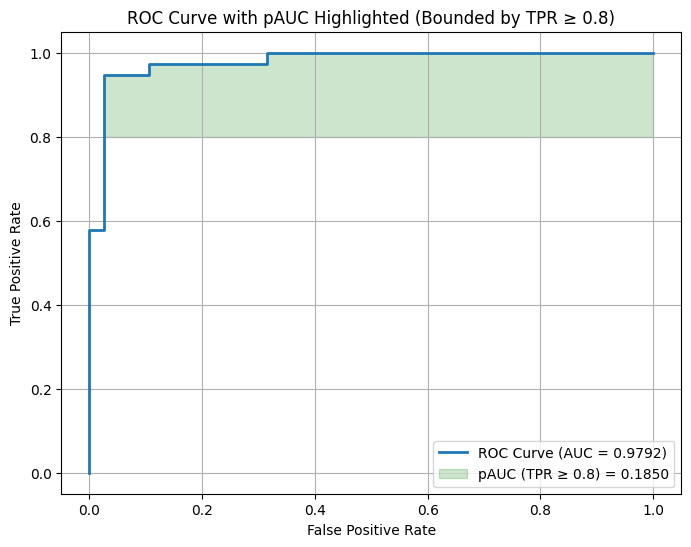

Corrected ROC Curve with pAUC saved at: ./roc_curve_with_pauc_corrected.png


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_true, y_pred_proba)


partial_auc = custom_metric(y_true, y_pred_proba, min_tpr=0.8)
print(f"Partial AUC (pAUC): {partial_auc:.4f}")


tpr_threshold = 0.8


valid_indices = tpr >= tpr_threshold


fpr_interp = np.interp(tpr_threshold, tpr, fpr)


fpr_bounded = np.concatenate(([fpr_interp], fpr[valid_indices]))
tpr_bounded = np.concatenate(([tpr_threshold], tpr[valid_indices]))


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.4f})", linewidth=2)


plt.fill_between(
    fpr_bounded, 
    tpr_bounded, 
    tpr_threshold, 
    color="green", 
    alpha=0.2, 
    label=f"pAUC (TPR ≥ {tpr_threshold}) = {partial_auc:.4f}"
)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with pAUC Highlighted (Bounded by TPR ≥ 0.8)")
plt.legend(loc="lower right")
plt.grid(True)


roc_curve_path = "./roc_curve_with_pauc_corrected.png"
plt.savefig(roc_curve_path, bbox_inches="tight")
plt.show()

print(f"Corrected ROC Curve with pAUC saved at: {roc_curve_path}")